# Do Nets Matter?
#### Author: JP Melo

In this file we explore how different shapes of nets affect performance and accuracy of the model. We will use the same dataset as before, but we will create different nets with different shapes and compare their performance.

### Imports

In [62]:
from derpinns.nn import *
from derpinns.utils import *
from derpinns.trainer import *
import torch
import kfac

## Parameters

In [63]:
# Fix seed for reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Global parameters
assets = 1

sampler = "pseudo"
device = torch.device("cpu")
dtype = torch.float32

# Define option valuation params
params = OptionParameters(
    n_assets=assets,
    tau=1.0,
    sigma=np.array([0.2] * assets),
    rho=np.eye(assets) + 0.25 * (np.ones((assets, assets)) - np.eye(assets)),
    r=0.05,
    strike=15,
    payoff=payoff
)

# Define the number of samples to be used in each training stage

adam_batch_size = 200
adam_total_iter = 200
adam_boundary_samples = 20_000
adam_interior_samples = adam_boundary_samples*assets*2
adam_initial_samples = adam_boundary_samples*assets*2

lbfgs_boundary_samples = 200
lbfgs_interior_samples = lbfgs_boundary_samples*assets*2
lbfgs_initial_samples = lbfgs_boundary_samples*assets*2

## Training

In this case, we use the full training pipeline as the idea is to analize the expressability of the model and not the training process.

### FFNN

In [64]:
nn_shape = "64x2"
model = build_nn(
    nn_shape=nn_shape,
    input_dim=assets,
    dtype=torch.float32
).apply(weights_init).to(device)
model.train()

dataset = SampledDataset(
    params, adam_interior_samples, adam_initial_samples, adam_boundary_samples, sampler, dtype, device, seed=0)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
preconditioner = kfac.preconditioner.KFACPreconditioner(model)

closure = DimlessBS()\
    .with_dataset(dataset, loader_opts={'batch_size': adam_batch_size, "shuffle": True, "pin_memory": True})\
    .with_model(model)\
    .with_device(device)\
    .with_dtype(dtype)

trainer = PINNTrainer()\
    .with_optimizer(optimizer)\
    .with_device(device)\
    .with_dtype(dtype)\
    .with_training_step(closure)\
    .with_preconditioner(preconditioner)\
    .with_epochs(adam_total_iter)\

# first training stage
trainer.train()

# we create new samples for the second stage
dataset = SampledDataset(
    params, lbfgs_interior_samples, lbfgs_initial_samples, lbfgs_boundary_samples, sampler, dtype, device, seed=0)

optimizer = SSBroyden(
    model.parameters(),
    max_iter=2_000,
)
batch_size = len(dataset)  # we use all samples

closure = closure.with_dataset(
    dataset, loader_opts={'batch_size': batch_size, "shuffle": False, "pin_memory": True})

trainer = trainer.with_optimizer(optimizer).with_training_step(closure)

# second training stage
trainer.train()

# save the model
torch.save(model.state_dict(), "ffnn.pth")

ffnn = model

SSBroyden training:  28%|██▊       | 566/2000 [03:05<07:50,  3.05it/s, Interior=0.000000, Boundary=0.000000, Initial=0.000000, Total=0.000000, Max Error=0.003956, L2 Error=0.000113]


In [65]:
with_vanilla = trainer.closure.get_state()
plot_loss(with_vanilla, smooth=True, smooth_window=50)

vanilla_l2 = compare_with_mc(model, params, n_prices=200,
                             n_simulations=50_000, dtype=dtype, device=device, seed=42)['l2_rel_error']
print("L2 Error: ", vanilla_l2*100)

L2 Error:  0.009018164


## With SPINN

In [66]:
# model = SPINN(n_layers=2, input_dim=assets+1, hidden_dim=20,
# output_dim=20, dtype=dtype).apply(weights_init).to(device)

# dataset = SampledDataset(
#     params, adam_interior_samples, adam_initial_samples, adam_boundary_samples, sampler, dtype, device, seed=0)

# optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
# preconditioner = kfac.preconditioner.KFACPreconditioner(model)

# closure = DimlessBS()\
#     .with_dataset(dataset, loader_opts={'batch_size': adam_batch_size, "shuffle": True, "pin_memory": True})\
#     .with_model(model)\
#     .with_device(device)\
#     .with_dtype(dtype)

# trainer = PINNTrainer()\
#     .with_optimizer(optimizer)\
#     .with_device(device)\
#     .with_dtype(dtype)\
#     .with_training_step(closure)\
#     .with_preconditioner(preconditioner)\
#     .with_epochs(adam_total_iter)\

# # first training stage
# trainer.train()

# # we create new samples for the second stage
# dataset = SampledDataset(
#     params, lbfgs_interior_samples, lbfgs_initial_samples, lbfgs_boundary_samples, sampler, dtype, device, seed=0)

# optimizer = SSBroyden(
#     model.parameters(),
#     max_iter=2_000,
#     initial_scale=True,
# )

# batch_size = len(dataset)  # we use all samples

# closure = closure.with_dataset(
#     dataset, loader_opts={'batch_size': batch_size, "shuffle": False, "pin_memory": True})

# trainer = trainer.with_optimizer(optimizer).with_training_step(closure)

# # second training stage
# trainer.train()

# # we save the model
# torch.save(model.state_dict(), "spinn.pth")
# spinn = model

In [67]:
# with_spinn = trainer.closure.get_state()
# plot_loss(with_spinn, smooth=True, smooth_window=50)

# spinn_l2 = compare_with_mc(model, params, n_prices=200,
#                            n_simulations=50_000, dtype=dtype, device=device, seed=42)['l2_rel_error']
# print("L2 Error: ", spinn_l2*100)

## With NN+Ansatz

In [68]:
model = NNWithAnsatz(n_layers=2, input_dim=assets+1, hidden_dim=64,
                 output_dim=1, dtype=dtype).apply(weights_init).to(device)

dataset = SampledDataset(
    params, adam_interior_samples, adam_initial_samples, adam_boundary_samples, sampler, dtype, device, seed=0)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
preconditioner = kfac.preconditioner.KFACPreconditioner(model)

closure = DimlessBS()\
    .with_dataset(dataset, loader_opts={'batch_size': adam_batch_size, "shuffle": True, "pin_memory": True})\
    .with_model(model)\
    .with_device(device)\
    .with_dtype(dtype)

trainer = PINNTrainer()\
    .with_optimizer(optimizer)\
    .with_device(device)\
    .with_dtype(dtype)\
    .with_training_step(closure)\
    .with_preconditioner(preconditioner)\
    .with_epochs(adam_total_iter)\

# first training stage
trainer.train()

# we create new samples for the second stage
dataset = SampledDataset(
    params, lbfgs_interior_samples, lbfgs_initial_samples, lbfgs_boundary_samples, sampler, dtype, device, seed=0)

optimizer = SSBroyden(
    model.parameters(),
    max_iter=2_000,
)

closure = DimlessBS()\
    .with_dataset(dataset, loader_opts={'batch_size': adam_batch_size, "shuffle": True, "pin_memory": True})\
    .with_model(model)\
    .with_device(device)\
    .with_dtype(dtype)

batch_size = len(dataset)  # we use all samples

closure = closure.with_dataset(
    dataset, loader_opts={'batch_size': batch_size, "shuffle": False, "pin_memory": True})

trainer = trainer.with_optimizer(optimizer).with_training_step(closure)

# second training stage
trainer.train()

# save model
torch.save(model.state_dict(), "ansatz_ffnn.pth")
ansatz_ffnn = model

Adam training:   0%|          | 0/200 [00:00<?, ?it/s]

SSBroyden training:   5%|▍         | 91/2000 [00:39<13:53,  2.29it/s, Interior=0.000005, Boundary=0.000000, Initial=0.000000, Total=0.000005, Max Error=0.053156, L2 Error=0.001187]


In [69]:
with_anzats = trainer.closure.get_state()
plot_loss(with_anzats, smooth=True, smooth_window=50)

anzats_l2 = compare_with_mc(model, params, n_prices=200,
                            n_simulations=50_000, dtype=dtype, device=device, seed=42)['l2_rel_error']
print("L2 Error: ", anzats_l2*100)

L2 Error:  0.6467107


### FOPINN  

In [70]:
model = FirstOrderNN(n_layers=2, input_dim=assets+1, hidden_dim=64, dtype=dtype).apply(weights_init).to(device)

dataset = SampledDataset(
    params, adam_interior_samples, adam_initial_samples, adam_boundary_samples, sampler, dtype, device, seed=0)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
preconditioner = kfac.preconditioner.KFACPreconditioner(model)

closure = FOPINNClosure()\
    .with_dataset(dataset, loader_opts={'batch_size': adam_batch_size, "shuffle": True, "pin_memory": True})\
    .with_model(model)\
    .with_device(device)\
    .with_dtype(dtype)

trainer = PINNTrainer()\
    .with_optimizer(optimizer)\
    .with_device(device)\
    .with_dtype(dtype)\
    .with_training_step(closure)\
    .with_preconditioner(preconditioner)\
    .with_epochs(adam_total_iter)\

# first training stage
trainer.train()

# we create new samples for the second stage
dataset = SampledDataset(
    params, lbfgs_interior_samples, lbfgs_initial_samples, lbfgs_boundary_samples, sampler, dtype, device, seed=0)

optimizer = SSBroyden(
    model.parameters(),
    max_iter=2_000,
)

batch_size = len(dataset)  # we use all samples

closure = closure.with_dataset(
    dataset, loader_opts={'batch_size': batch_size, "shuffle": False, "pin_memory": True})

trainer = trainer.with_optimizer(optimizer).with_training_step(closure)

# second training stage
trainer.train()

# save model
torch.save(model.state_dict(), "fo_pinn.pth")

fo_pinn = model

Adam training:   0%|          | 0/200 [00:00<?, ?it/s]

SSBroyden training:  54%|█████▎    | 1071/2000 [05:48<05:02,  3.07it/s, Interior=0.000000, Boundary=0.000000, Initial=0.000000, Total=0.000001, Max Error=0.004530, L2 Error=0.000106]


In [71]:
with_fo = trainer.closure.get_state()
plot_loss(with_fo, smooth=True, smooth_window=50)

fo_l2 = compare_with_mc(model, params, n_prices=200,
                            n_simulations=50_000, dtype=dtype, device=device, seed=42, split_output=True)['l2_rel_error']
print("L2 Error: ", fo_l2*100)

L2 Error:  0.014275366


In [84]:
import numpy as np

def compare_error_histories(
    runs,
    labels=None,
    save_path: str = None,
    backend: str = "plotly",
    fig_size=(900, 600),
    smooth: bool = True,
    smooth_window: int = 50,
    yscale: str = "power10",
):
    """
    Plot L₂ relative-error over training for multiple runs,
    allowing runs of different lengths.

    Parameters
    ----------
    runs : list of dicts with key 'l2_rel_err'
    labels : list of str, one per run
    save_path : if given, write figure to this path
    backend : 'plotly' or 'matplotlib'
    fig_size : (width, height) pixels for Plotly, inches (dpi=100) for Matplotlib
    smooth : apply moving‐average smoothing?
    smooth_window : window size for smoothing
    yscale : 'linear', 'log', or 'power10'
    """
    n = len(runs)
    assert n > 0, "Need at least one run to compare"
    if labels is None:
        labels = [f"Run {i+1}" for i in range(n)]
    assert len(labels) == n

    # prepare data (only L2)
    histories = []
    for d in runs:
        l2 = np.asarray(d["l2_rel_err"], dtype=float)
        if smooth:
            l2 = _moving_average(l2, smooth_window)
        histories.append(l2)

    # color cycle
    colors = ["#08306B", "#08519C",
                "#3182BD", "#6BAED6", "#9ECAE1", "#C6DBEF"]

    backend = backend.lower()

    if backend == "plotly":
        import plotly.graph_objs as go

        fig = go.Figure()
        for idx, l2 in enumerate(histories):
            fig.add_trace(
                go.Scatter(
                    x=np.arange(len(l2)),
                    y=l2,
                    mode="lines",
                    name=labels[idx],
                    line=dict(color=colors[idx % len(colors)])
                )
            )

        # y-scale
        if yscale == "linear":
            fig.update_yaxes(type="linear")
        else:
            fig.update_yaxes(type="log")
            if yscale == "power10":
                fig.update_yaxes(
                    exponentformat="power",
                    showexponent="all"
                )

        fig.update_layout(
            title="$L_2$ Relative Error over Training",
            xaxis_title="Iteration",
            yaxis_title="rel $L_2$ error",
            width=fig_size[0], height=fig_size[1],
            legend_title="Run",
            template="plotly_white"
        )

        if save_path:
            fig.write_image(save_path)
        else:
            fig.show()

    elif backend == "matplotlib":
        import matplotlib.pyplot as plt
        from matplotlib.ticker import LogFormatterMathtext

        # convert px → inches for Matplotlib at dpi=100
        fig, ax = plt.subplots(
            1, 1,
            figsize=(fig_size[0]/100, fig_size[1]/100),
            squeeze=True
        )

        for idx, l2 in enumerate(histories):
            ax.plot(
                np.arange(len(l2)),
                l2,
                label=labels[idx],
                color=colors[idx % len(colors)]
            )

        # y-scale
        if yscale == "linear":
            ax.set_yscale("linear")
        elif yscale == "log":
            ax.set_yscale("log")
        elif yscale == "power10":
            ax.set_yscale("log")
            ax.yaxis.set_major_formatter(LogFormatterMathtext())
        else:
            raise ValueError(f"Unknown yscale {yscale!r}")

        ax.set_title("$L_2$ Relative Error over Training")
        ax.set_xlabel("Iteration")
        ax.set_ylabel("Relative $L_2$ Error")
        ax.legend(loc="upper right")
        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300)
            plt.close(fig)
        else:
            plt.show()

    else:
        raise ValueError(f"Unsupported backend: {backend!r}")


### Compare runs

In [85]:
compare_error_histories(
    [with_vanilla, with_anzats, with_fo],
    labels=["FFNN", "FFNN with Ansatz", "FOPINN"],
    smooth=False,
    backend="matplotlib",
    save_path="imgs/nets_error_histories.png",
    fig_size=(800, 400),
)

The neural network with the modifed output (ansatz) is able to get a good accuracy very fast but gets stuck and is not able to progress further. The SPINN model is able to get better accuracy in the long run but it requires more computing.

In [73]:
# load models
ffnn = build_nn(
    nn_shape='64x2',
    input_dim=assets,
    dtype=torch.float32
)
ffnn.load_state_dict(torch.load("ffnn.pth"))
ffnn.eval()
ansatz_ffnn = NNWithAnsatz(n_layers=2, input_dim=assets+1, hidden_dim=64,
                 output_dim=1, dtype=dtype).apply(weights_init).to(device)
ansatz_ffnn.load_state_dict(torch.load("ansatz_ffnn.pth"))
ansatz_ffnn.eval()
fo_pinn = FirstOrderNN(n_layers=2, input_dim=assets+1, hidden_dim=64, dtype=dtype).apply(weights_init).to(device)
fo_pinn.load_state_dict(torch.load("fo_pinn.pth"))
fo_pinn.eval()

FirstOrderNN(
  (hidden_layers): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Tanh()
  )
  (output_layer): Linear(in_features=64, out_features=3, bias=True)
)

In [74]:
compare_solution_surfaces(
    [ffnn, fo_pinn, ansatz_ffnn],
    params,
    assets=assets,
    device=device,
    labels=["FFNN", "FOPINN", "FNN with Ansatz"],
    save_path="imgs/nets_surfaces.png",
    backend="matplotlib",
    fig_size=(600, 500),
    real_solution=True,
    view=(25,120)    # tilt/rotate as you like
)

/Users/josemelo/Desktop/master/tesis/codes/derivative_pinns/src/derpinns/utils.py:1027: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



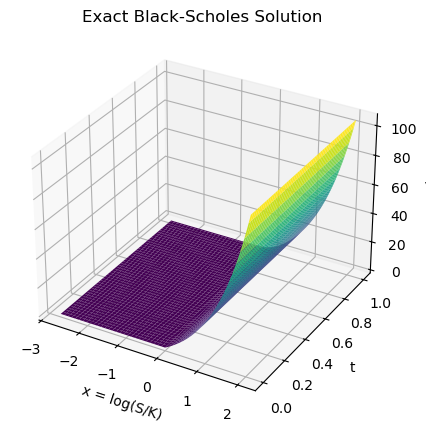

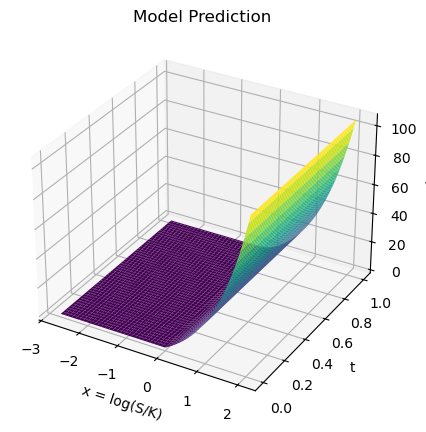

/var/folders/cp/l432p0ns1t38qmnyr_3l3r000000gn/T/ipykernel_47642/4275293301.py:115: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



In [83]:
compare_error_heatmaps(
    [ffnn, fo_pinn, ansatz_ffnn],
    params,
    device=device,
    labels=["FFNN", "FOPINN", "FNN with Ansatz"],
    save_path="imgs/nets_heatmaps.png",
    backend="matplotlib",
    cmap="mako",
    fig_size=(6, 6),                   #  inches per panel  (width , height)
    )